# Applying Langevin Thermostat

$$ M\frac{d^2X}{dt^2} = -\nabla U(X)-\gamma M \frac{dX}{dt}+\sqrt{2M \gamma k_BT} \ R(t) $$

where R(t) is a zero mean Gaussian with variance $\sqrt{2M \gamma k_BT}/\Delta t$

In order to simplify the case, we eliminate the interaction potential. (noninteracting particles)

Initial velocities chosen from a uniform random number generator and at the end of notebook you are going to see that they obey the Maxwell-Boltzmann Distribution. In the next notebook, we will initialize them with Maxwell-Boltzmann Dist. 

In [1]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plth
import matplotlib.pylab as plt
import math
from IPython import display
import time

In [2]:
params = {
    "natoms" : 1000, "temp"   : 300,"mass"   : 0.001,"radius" : 120e-12,"relax"  : 1e-13,"dt"     : 1e-15,
    "nsteps" : 10000,"freq"   : 100,"box"    : ((0, 1e-8), (0, 1e-8), (0, 1e-8))
}
Avogadro = 6.02214086e23
Boltzmann = 1.38064852e-23

In [3]:
def ComputeForce(mass_grp,vels,temp,relax,dt):
    
    natoms,dimension=vels.shape
    
    sigma = np.sqrt(2.0 * mass_grp * temp * Boltzmann / (relax * dt))
    random_force = np.random.randn(natoms,dimension) * sigma[:,np.newaxis]
    net_force = -(vels * mass_grp[:,np.newaxis]) / relax + random_force
    return random_force,net_force

In [4]:
def integrate(positions,forces,vels,dt,mass_grp):
    
    positions += vels *dt
    vels += forces * dt / mass_grp[:,np.newaxis]

In [5]:
def CheckBoundary(positions,vels,box,dimension):
    
    for i in range(dimension):
        vels[((positions[:,i] <= box[i][0]) | (positions[:,i] >= box[i][1])),i] *= -1

In [6]:
def run(natoms,temp,mass,radius,relax,dt,nsteps,freq,box):
    
    global trajectory    
    dimension=len(box)
    positions=np.random.rand(natoms,dimension)
    for i in range(dimension):
        positions[:,i] = box[i][0] + (box[i][1]-box[i][0]) * positions[:,i]
        
    vels=np.random.rand(natoms,dimension)
    
    mass_grp=np.ones(natoms) * mass / Avogadro
    radius_grp=np.ones(natoms) * radius
    step=0    
    output=[]
    
    while step <= nsteps:       
        #Compute forces
        noise,forces=ComputeForce(mass_grp,vels,temp,relax,dt)
            #time iteration
        integrate(positions,forces,vels,dt,mass_grp)
            #Boundary conditions
        CheckBoundary(positions,vels,box,dimension)
            #Calculate Temperature
        inst_temperature = np.sum(np.dot(mass_grp,(vels-vels.mean(axis=0))**2)/(natoms*Boltzmann*dimension))
        output.append([step*dt,inst_temperature])       
        step += 1     
    #####For dynamic plots
        #plt.plot(np.array(output)[:,0]*1e12,np.array(output)[:,1])
        #plt.plot(positions[:,0],positions[:,1],'ro')
        #plt.ylim([-20,350])
        #plt.xlim([-1,10])
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        #time.sleep(0.001)
    return np.array(output),vels

In [7]:
out1,out2=run(**params)

### Temperature

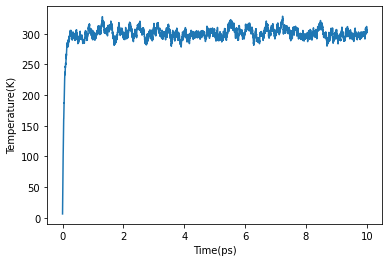

In [8]:
plt.xlabel("Time(ps)")
plt.ylabel("Temperature(K)")
plt.plot(out1[:,0]*1e12,out1[:,1])

### Speed Distribution (Maxwell - Boltzmann Dist.)

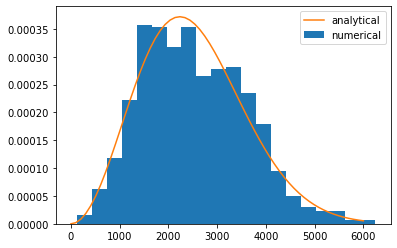

In [9]:
mass_in_kg=params["mass"]/Avogadro
sigma_boltz=np.sqrt(Boltzmann*params["temp"]/mass_in_kg)
speed=np.sqrt(out2[:,0]**2+out2[:,1]**2+out2[:,2]**2)
plth.hist(speed,bins=20,density=True,label="numerical")
x=np.linspace(0,6000,60)
y=4*np.pi*x**2*((mass_in_kg/(2*np.pi*Boltzmann*params["temp"]))**(3/2))*np.exp((-mass_in_kg*x**2)/(2*Boltzmann*params["temp"]))
plth.plot(x,y,label="analytical")
plth.legend(loc="upper right")
plth.show()